In [2]:
!pip3 install numpy
!pip3 install opencv-python
!pip3 install open3d
!pip3 install matplotlib

import numpy as np
import cv2
import glob
import os
import open3d as o3d
import matplotlib.pyplot as plt

# 1. Camera Calibration
checkerboardsize = (9, 7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((checkerboardsize[0] * checkerboardsize[1], 3), np.float32)
objp[:, :2] = np.mgrid[0 : checkerboardsize[0], 0 : checkerboardsize[1]].T.reshape(
    -1, 2
)

objpoints = []
imgpoints = []

base_path = "/home/rafay/Documents/rafay/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv"
images = glob.glob("calibration_data_logitech_3840x2160/*.jpg")
images = sorted([os.path.join(base_path, img_path) for img_path in images])
annotation_dir = "chessboard_corners"
save_chessboard_corner_ann = True
if not os.path.exists(annotation_dir) and save_chessboard_corner_ann:
    os.mkdir(annotation_dir)


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(
        gray,
        checkerboardsize,
        cv2.CALIB_CB_ADAPTIVE_THRESH
        + cv2.CALIB_CB_FAST_CHECK
        + cv2.CALIB_CB_NORMALIZE_IMAGE,
    )

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        if save_chessboard_corner_ann:
            fname_ = (
                os.path.join(base_path, annotation_dir)
                + "/"
                + fname.split("/")[-1].split(".")[0]
                + "corner_plot.jpg"
            )
            cv2.drawChessboardCorners(img, checkerboardsize, corners2, ret)
            cv2.imwrite(fname_, img)

ret, cameraMatrix, dist, rvec, tvec = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

# Compute reprojection error
reprojection_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvec[i], tvec[i], cameraMatrix, dist
    )
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    reprojection_error += error
reprojection_error /= len(objpoints)
print("Reprojection error:", reprojection_error)
print("Camera Calibrated:   ", ret)
print("Camera Matrix:   ", cameraMatrix)
print("Distortion Parameters:   ", dist)
print("Rotation Vector: ", rvec)
print("Translation Vector: ", tvec)


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Reprojection error: 0.14875925765044806
Camera Calibrated:    1.3396757464751792
Camera Matrix:    [[2.25370759e+03 0.00000000e+00 1.92969309e+03]
 [0.00000000e+00 2.24471892e+03 1.05763445e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:    [[ 2.08993190e-01 -5.57647266e-01 -7.19877887e-06  5.16897145e-04
   3.81154053e-01]]
Rotation Vector:  (array([[ 0.0

# Camera Calib

# Rectification

In [3]:
def stereo_rectify(K0, K1, R, T, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0, K1), rotation (R), 
    translation (T) between the two cameras, and the image size, and returns 
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth 
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R: Rotation matrix between the two cameras (3x3 numpy array).
        T: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T = T.astype(np.float64)  # Ensure T is float64 for cv2.stereoRectify

    R1, R2, P1, P2, Q = cv2.stereoRectify(K0, None, K1, None, image_size, R, T)
    return R1, R2, P1, P2, Q

# Disparity

In [69]:
def compute_disparity_map(imgL, imgR, ndisp, mindis):
    """
    Compute disparity map from stereo images.

    Parameters:
    - imgL (numpy.ndarray): Left image as a grayscale numpy array.
    - imgR (numpy.ndarray): Right image as a grayscale numpy array.
    - ndisp (int): Upper bound on disparity levels.
    - mindis (int): Minimum disparity value.
    Returns:
    - disparity_map (numpy.ndarray): Disparity map as a float32 numpy array.

    This function uses the StereoSGBM algorithm to compute the disparity map from the left and right images.
    The disparity map is a 2D array where each pixel value represents the disparity between the corresponding points in the left and right images.
    The disparity map is computed using the StereoSGBM algorithm, which is a block-matching algorithm that estimates the disparity by finding the
    best match for each block of pixels in the left image in the right image. The algorithm uses a cost function to measure the similarity between
    the blocks and selects the block with the lowest cost as the best match. The disparity map is then computed by dividing the difference in pixel
    positions between the left and right images by the baseline.

    The function takes as input the left and right images as grayscale numpy arrays, as well as the upper bound on disparity levels (ndisp) and
    the minimum disparity value (mindis). The function returns the disparity map as a float32 numpy array.
    """
    # Using StereoSGBM for better results (more parameters to tune)
    stereo = cv2.StereoSGBM_create(
        minDisparity=mindis,
        numDisparities=ndisp,
        blockSize=11,  # You can experiment with this value (odd numbers: 3, 5, 7, ...)
        P1=8 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        P2=32 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        disp12MaxDiff=1,
        preFilterCap=63,  # add this parameter
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
    )

    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    mask = disparity_map > 0  # Example: keep only positive disparities
    disparity_map = disparity_map * mask.astype(np.float32)
    return disparity_map

In [60]:
# Example usage (replace with your actual paths)
dataset_name = "random"  # "Bike" or "Umbrella" or "Cycle"
calibration_file_path = f"{dataset_name}/calibration_info.txt"
left_image = "dataset/d3/img1.jpg"
right_image = "dataset/d3/img2.jpg"

# 2. Read Images
imgL = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image) # For color visualization

baseline = 140
K0 = np.array(cameraMatrix)
K1 = np.array(cameraMatrix)
R = np.eye(3)  # Identity matrix (no rotation)
T = np.array([[baseline], [0], [0]])  # Baseline of 193.001 mm along the x-axis
image_size = (int(3840), int(2160))
# ndisp = int(calib_data["ndisp"])
# mindist = int(calib_data["vmin"])

In [61]:
# Step 1: Detect and match keypoints in the two images
# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
 
# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
 
# Filter matches using the Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
 
# Extract matched keypoints
pts_left = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches])
pts_right = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches])
 
# Step 2: Compute the Essential Matrix
E, mask = cv2.findEssentialMat(pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0)
 
# Step 3: Decompose the Essential Matrix to recover R and T
_, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)
 
print("Relative Rotation (R):\n", R)
print("Relative Translation (T):\n", T)

Relative Rotation (R):
 [[ 0.99995556  0.00727566  0.00599492]
 [-0.00704915  0.99929131 -0.03697563]
 [-0.0062597   0.03693172  0.99929819]]
Relative Translation (T):
 [[ 0.99675361]
 [-0.03776502]
 [ 0.07110579]]


In [62]:
# Stereo rectification using assumed R and T (no rotation, baseline translation)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K0, None, K1, None, image_size, R, T, alpha=0
)

In [63]:
R1, R2, P1, P2, Q

(array([[ 0.99653043, -0.02786016,  0.07842774],
        [ 0.02929043,  0.99942388, -0.01714564],
        [-0.07790487,  0.01938333,  0.99677235]]),
 array([[ 0.99675361, -0.03776502,  0.07110579],
        [ 0.03645781,  0.99914309,  0.01959349],
        [-0.07178481, -0.01693752,  0.99727632]]),
 array([[2.65117899e+03, 0.00000000e+00, 1.63882005e+03, 0.00000000e+00],
        [0.00000000e+00, 2.65117899e+03, 1.05171872e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[2.65117899e+03, 0.00000000e+00, 1.63882005e+03, 2.65117899e+03],
        [0.00000000e+00, 2.65117899e+03, 1.05171872e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.63882005e+03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -1.05171872e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.65117899

In [64]:
def reconstruct_3D(disparity_map: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """Reconstructs 3D points from a disparity map using a Q matrix.

    This function takes a disparity map and a Q (disparity-to-depth) matrix 
    and uses OpenCV's `cv2.reprojectImageTo3D` to reconstruct a 3D point cloud.

    Args:
        disparity_map: The disparity map (NumPy array, usually float32).
        Q: The disparity-to-depth mapping matrix (4x4 NumPy array).

    Returns:
        A 3D point cloud (NumPy array).  The shape of the returned array 
        is (height, width, 3), where each element [y, x, :] represents the 
        3D coordinates (x, y, z) of the point corresponding to pixel (x, y) 
        in the disparity map.  Returns None if there is an error.
    """
    try:
        points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
        return points_3D
    except Exception as e:
        print(f"Error in reconstruct_3D: {e}")
        return None

In [65]:
def visualize_point_cloud(
    points_3D: np.ndarray, colors: np.ndarray, disparity_map: np.ndarray
):
    """Visualizes the 3D point cloud using Open3D.

    This function takes 3D points, colors, and a disparity map, filters out
    invalid points (NaN, infinite, or where disparity is zero or negative),
    and visualizes the point cloud using Open3D.

    Args:
        points_3D: 3D point cloud (NumPy array of shape (H, W, 3)).
        colors: Color information for each point (NumPy array of shape (H, W, 3) or (N, 3)).
        disparity_map: Disparity map (NumPy array of shape (H, W)).
    """
    try:
        # Mask invalid points (NaN, infinite, or where disparity is <= 0)
        mask = (
            ~np.isnan(points_3D[:, :, 0])
            & ~np.isinf(points_3D[:, :, 0])
            & (disparity_map > 0)
        )

        if not np.any(mask):  # Check if there are any valid points before proceeding
            print("Warning: No valid points to visualize after masking.")
            return  # Exit early if there are no valid points

        valid_points = points_3D[mask]
        valid_colors = colors[mask]

        point_cloud = o3d.geometry.PointCloud()
        point_cloud.points = o3d.utility.Vector3dVector(
            valid_points
        )  # No need to reshape now
        point_cloud.colors = o3d.utility.Vector3dVector(
            valid_colors / 255.0
        )  # Normalize colors

        o3d.visualization.draw_geometries([point_cloud])

    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")

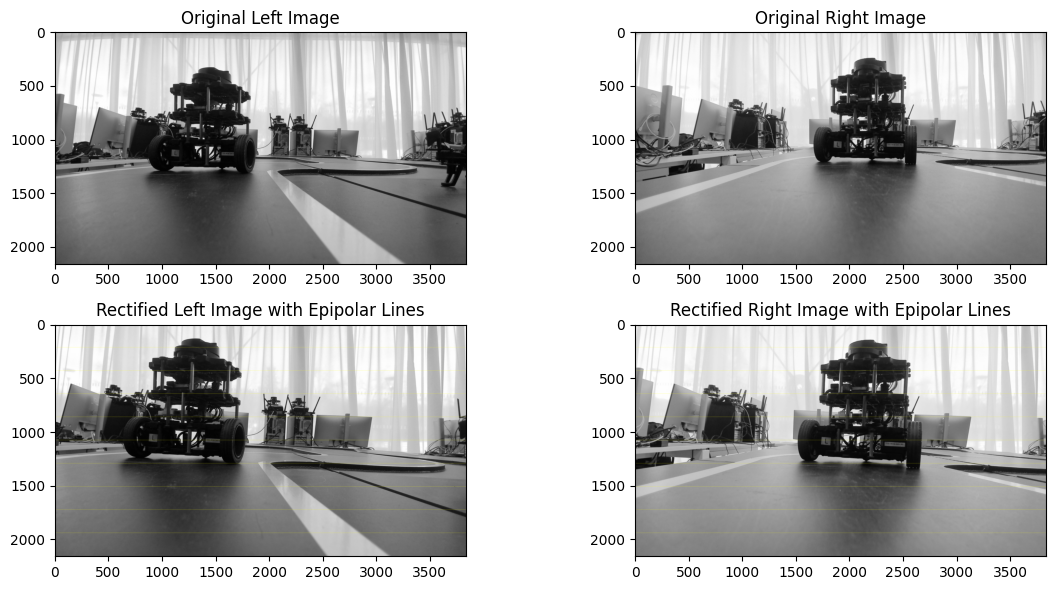

True

In [68]:
# 4. Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_16SC2)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)


# Draw epipolar lines for evaluation
def draw_epipolar_lines(img1, img2, num_lines=10):
    # Create a copy of the images to draw lines on
    img1_lines = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_lines = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Draw horizontal lines on both images
    for i in range(0, img1.shape[0], img1.shape[0] // num_lines):
        cv2.line(img1_lines, (0, i), (img1.shape[1], i), (255, 255, 0), 1)
        cv2.line(img2_lines, (0, i), (img2.shape[1], i), (255, 255, 0), 1)

    return img1_lines, img2_lines


# Draw epipolar lines on the rectified images
left_rectified_lines, right_rectified_lines = draw_epipolar_lines(imgL_rect, imgR_rect)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(left_rectified_lines)

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(right_rectified_lines)

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite("left_rectified.jpg", imgL_rect)
cv2.imwrite("right_rectified.jpg", imgR_rect)
cv2.imwrite("right_rectified_lines.jpg", right_rectified_lines)
cv2.imwrite("left_rectified_lines.jpg", left_rectified_lines)


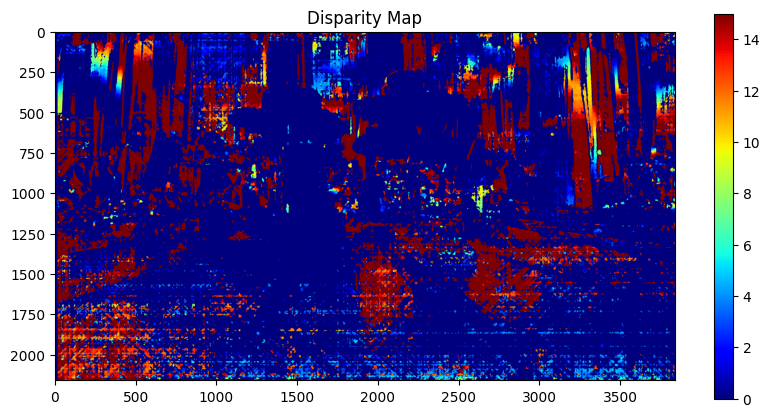

libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [70]:
# 5. Disparity Calculation
disparity_map = compute_disparity_map(imgL, imgR, 16, 0)

plt.figure(figsize=(10,5))
plt.imshow(disparity_map, cmap='jet')
plt.title("Disparity Map")
plt.colorbar()
plt.show()

# 6. 3D Reconstruction
points_3D = reconstruct_3D(disparity_map, Q)
# 7. Visualization
visualize_point_cloud(points_3D, cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB), disparity_map)

#Optional: Save the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
o3d.io.write_point_cloud(f"{dataset_name}_point_cloud.ply", pcd)